### -1, Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, r2_score
from utils import *
from scipy.sparse.linalg import eigsh
import torch
from scipy.sparse import csr_array
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_friedman1

### 0, Simulate some data

In [178]:
# Data simulation with a Toeplitz covariance matrix, see utils for details.
X, y, beta, Sigma = simulate_data(n=1000, d=50, rho=0.9, seed=1080)
# X, y = make_friedman1(n_samples = 1000, n_features = 50)
data = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
data.rename(columns={data.shape[1]-1: 'y'}, inplace=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

### 1, Truncated eigendecomposition + Some plots

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                  random_state=1234)
# skrf = RandomForestRegressor(n_estimators=500, random_state=0)
skrf = RandomForestClassifier(n_estimators=500, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_val)

# access trees
# trees = skrf.estimators_
A, metadata = make_adjacency(skrf, X_train)

A_csr = csr_array(A)
# eigenvalues, eigenvectors = eigsh(A_csr, k = 500, which = 'LM')
# eigenvectors = eigenvectors[:, ::-1]
# eigenvalues = eigenvalues[::-1]
# eigenvalues = eigenvalues[1:]
# eigenvectors = eigenvectors[:, 1:]
# exact solution
eigenvalues, eigenvectors = np.linalg.eigh(A)
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

In [218]:
A_reconstruction = eigenvectors @ np.diag (eigenvalues) @ eigenvectors.T

In [219]:
A_reconstruction

array([[4.28526382e-02, 2.30428982e-03, 4.98394186e-18, ...,
        3.41831040e-03, 3.12500000e-05, 2.11182803e-04],
       [2.30428982e-03, 6.60440216e-02, 1.69491526e-05, ...,
        3.33535290e-03, 4.44444455e-05, 8.12679112e-04],
       [4.86535725e-18, 1.69491526e-05, 5.04047470e-02, ...,
        2.01932655e-18, 6.32040679e-04, 2.06905556e-03],
       ...,
       [3.41831040e-03, 3.33535290e-03, 1.89735380e-18, ...,
        3.27570305e-02, 2.20701218e-04, 4.25531901e-05],
       [3.12500000e-05, 4.44444455e-05, 6.32040679e-04, ...,
        2.20701218e-04, 1.54265518e-01, 1.83486231e-05],
       [2.11182803e-04, 8.12679112e-04, 2.06905556e-03, ...,
        4.25531901e-05, 1.83486231e-05, 2.36194824e-01]], shape=(720, 720))

In [224]:
# Checking that the reconstruction error is strictly monotonic 
A_scores = []
for i in [5, 10, 20, 50, 100, 200, 500, 720]:
    psi_I = eigenvectors[:, :i]
    lambda_I = eigenvalues[:i]
    A_I = psi_I @ np.diag(lambda_I) @ psi_I.T
    diff = A - A_I
    fro_norm = np.linalg.norm(diff, 'fro')
    A_scores.append(fro_norm)
A_scores

[np.float64(3.3584859967470835),
 np.float64(3.2377094795073194),
 np.float64(3.081437738777317),
 np.float64(2.757708641328033),
 np.float64(2.3542403315835183),
 np.float64(1.7610998039919623),
 np.float64(0.5671553053180738),
 np.float64(9.767952458005548e-15)]

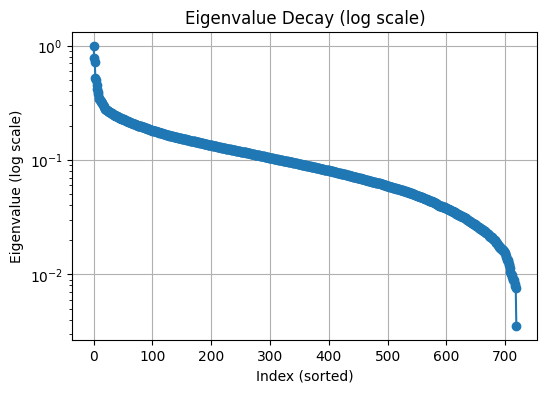

In [225]:
plt.figure(figsize=(6,4))
plt.semilogy(eigenvalues, marker='o')
plt.xlabel("Index (sorted)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalue Decay (log scale)")
plt.grid(True)
plt.show()

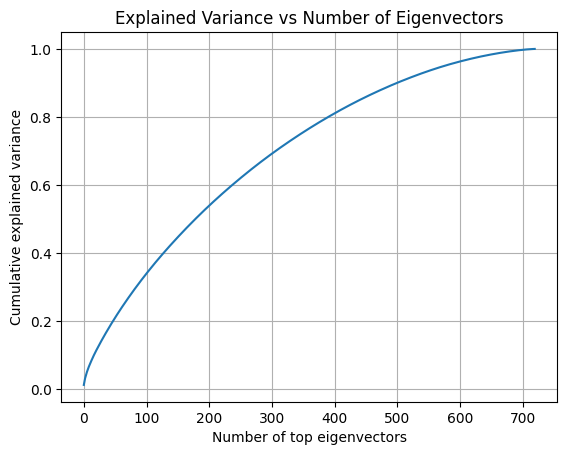

In [226]:
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.plot(explained_variance)
plt.xlabel("Number of top eigenvectors")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance vs Number of Eigenvectors")
plt.grid(True)
plt.show()

### 3, Define the eigen NN function

In [227]:
class eigenNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=256, hidden_dim2=512, use_cuda = False):
        super(eigenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
        self.use_cuda = use_cuda
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.to(self.device)
    def forward(self, x):
        return self.net(x)
    def train_epoch(self, train_loader, optimizer, epoch, log_interval, lambda_vec):
        self.train()
        training_loss_list = []


        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            output = self.forward(data)
            loss = torch.sum(lambda_vec * (output - target)**2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                msg = "Epoch: {:02d} | Batch {:03d} | Train Loss: {:.5f}"
                # print(msg.format(epoch, batch_idx, loss.item()))
                training_loss_list.append(loss.cpu().item())
        return training_loss_list
    def validate(self, val_loader, lambda_vec):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.forward(data)
                loss = torch.sum(lambda_vec * (output - target)**2)
                total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(val_loader.dataset)
        # print(f"Validation Avg Loss: {avg_loss:.5f}")
        return avg_loss
    def run_training(self, train_loader, val_loader, optimizer, epochs, lambda_vec=None, log_interval=5):
        val_acc_list = []
        all_training_losses = []
        print(f"Training on device: {self.device}")
        if lambda_vec is not None:
            lambda_vec = lambda_vec.to(self.device)
        else:
            lambda_vec = torch.ones(self.output_dim, device=self.device, dtype=torch.float32)
        for epoch in range(epochs):
            # print(f"\n-- Epoch {epoch} --")

            epoch_losses = self.train_epoch(train_loader, optimizer, epoch, log_interval, lambda_vec)
            all_training_losses.append(epoch_losses)

            avg_loss = self.validate(val_loader, lambda_vec)            
            val_acc_list.append(avg_loss)

        print('\n Training Complete. M value here is: ', self.output_dim)
        return all_training_losses, val_acc_list

In [228]:
lr = 1e-3
batch_size = 64
epochs = 100
input_dim = 50
use_cuda = True

In [229]:
M_vector = [5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 400]
M_scores = []
K_corr = []
K_test = new_adjacency(skrf, X_test, metadata)
A_new = new_adjacency(skrf, X_val, metadata)
for M in M_vector:
    output_dim = M
    lambda_M = eigenvalues.copy()
    psi_M = eigenvectors.copy()
    psi_M = psi_M[:, :M]
    lambda_M = lambda_M[:M]
    train_dataset = TabularDataset(X_train, psi_M)


    # Nystrom KPCA to make new validation set
    lambda_inv = np.diag(1.0/np.sqrt(lambda_M))
    psi_val = (lambda_inv @ psi_M.T @ A_new.T).T
    val_dataset = TabularDataset(X_val, psi_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size = batch_size,
        shuffle=True
    )

    # Weigh the coefficients
    lambda_vec = torch.exp(-0.5 * torch.arange(M, dtype=torch.float32))
    lambda_vec /= lambda_vec.sum()

    tree = eigenNN(input_dim=input_dim, output_dim=output_dim, use_cuda=use_cuda)
    optimizer = torch.optim.Adam(tree.parameters(), lr=lr)

    training_losses, validation_losses = tree.run_training(
        train_loader, 
        val_loader, 
        optimizer, 
        int(epochs * np.log(M)/2), 
        lambda_vec
    )

    device = next(tree.parameters()).device
    c = psi_M @ np.diag(lambda_M)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = tree(X_test_t).T
        
    K_estimate = (c @ output.cpu().numpy()).T
    K_truncated = np.maximum(K_estimate, 0)
    row_sums = K_truncated.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    K_normalized = K_truncated / row_sums

    #K_normalized = sparsemax(K_estimate)
    results = K_normalized @ y_train
    results[results > 0.5] = 1
    results[results < 0.5] = 0
    # accuracy_score(results, y_test)
    # score = r2_score(results, y_test)
    score = accuracy_score(results, y_test)
    K_score = np.linalg.norm(K_estimate - K_test, 'fro')
    M_scores.append(score)
    K_corr.append(K_score)
    print('Score at M =', M, 'is:', score)
    print('Matrix R2 at M=', M, 'is:', K_score)
    

Training on device: cuda

 Training Complete. M value here is:  5
Score at M = 5 is: 0.835
Matrix R2 at M= 5 is: 0.6917964320162893
Training on device: cuda

 Training Complete. M value here is:  10
Score at M = 10 is: 0.83
Matrix R2 at M= 10 is: 0.6313661675602024
Training on device: cuda

 Training Complete. M value here is:  20
Score at M = 20 is: 0.84
Matrix R2 at M= 20 is: 0.6286439225872043
Training on device: cuda

 Training Complete. M value here is:  40
Score at M = 40 is: 0.83
Matrix R2 at M= 40 is: 0.6457701263561192
Training on device: cuda

 Training Complete. M value here is:  60
Score at M = 60 is: 0.825
Matrix R2 at M= 60 is: 0.695917416522159
Training on device: cuda

 Training Complete. M value here is:  80
Score at M = 80 is: 0.82
Matrix R2 at M= 80 is: 0.8411598356275072
Training on device: cuda

 Training Complete. M value here is:  100
Score at M = 100 is: 0.81
Matrix R2 at M= 100 is: 0.9201253702122674
Training on device: cuda

 Training Complete. M value here is

In [132]:
def softmax_temperature(X, T=1.0):
    exp_X = np.exp(X / T)
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)
def sparsemax(X):
    # Apply row-wise
    Y = np.zeros_like(X)
    for i, x in enumerate(X):
        z = np.sort(x)[::-1]
        cssv = np.cumsum(z) - 1
        rho = np.nonzero(z > cssv / (np.arange(len(z)) + 1))[0][-1]
        tau = cssv[rho] / (rho + 1.0)
        Y[i] = np.maximum(x - tau, 0)
    return Y

In [ ]:
M = 40
output_dim = M

# Inspection
# Select your values for M here.
lambda_M = eigenvalues[:M]
psi_M = eigenvectors[:, :M].copy()
train_dataset = TabularDataset(X_train, psi_M)


# Nystrom KPCA to make new validation set
lambda_inv = np.diag(1.0/np.sqrt(lambda_M))
A_new = new_adjacency(skrf, X_val, metadata)
psi_val = (lambda_inv @ psi_M.T @ A_new.T).T
val_dataset = TabularDataset(X_val, psi_val)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)
# Weigh the coefficients
lambda_vec = torch.exp(-0.5 * torch.arange(M, dtype=torch.float32))
lambda_vec /= lambda_vec.sum()

# train the NN
tree = eigenNN(input_dim=input_dim, output_dim=output_dim, use_cuda=use_cuda)
optimizer = torch.optim.Adam(tree.parameters(), lr=lr)

training_losses, validation_losses = tree.run_training(
    train_loader, 
    val_loader, 
    optimizer, 
    epochs, 
    lambda_vec
)

In [63]:
device = next(tree.parameters()).device
c = psi_M @ np.diag(lambda_M)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    output = tree(X_test_t).T
    
K_estimate = (c @ output.cpu().numpy()).T
K_truncated = np.maximum(K_estimate, 0)
row_sums = K_truncated.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1

K_normalized = K_truncated / row_sums
results = K_normalized @ y_train
# results[results > 0.5] = 1
# results[results < 0.5] = 0
# accuracy_score(results, y_test)
r2_score(results, y_test)

0.4093464490855687

In [64]:
# checking the model predictions against the training labels
device = next(tree.parameters()).device
c = psi_M @ np.diag(lambda_M)
X_train_t = torch.tensor(X_train.values, dtype=torch.float32).to(device)
with torch.no_grad():
    output = tree(X_train_t).T
K_estimate = (c @ output.cpu().numpy()).T
K_truncated = np.maximum(K_estimate, 0)
row_sums = K_truncated.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
K_normalized = K_truncated / row_sums
results = K_normalized.T @ y_train
r2_score(results, y_train)

0.5017530288036847

In [65]:
# checking the kernel approximation against the training data
K_approximate = (c @ output.cpu().numpy()).T
K_truncated_approx = np.maximum(K_approximate, 0)

row_sums = K_truncated_approx.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1

K_normalized_approx = K_truncated_approx / row_sums
results_approx = K_normalized_approx.T @ y_train
r2_score(results_approx, y_train)

0.5017530288036847

### 4, New Idea 2: Decision Tree???

In [72]:
DTR = DecisionTreeRegressor(random_state=0, max_depth=5)
DTR.fit(X_train, psi_M)
output = DTR.predict(X_test).T
K_estimate_DT = (c @ output).T
K_truncated_DT = np.maximum(K_estimate_DT, 0)
row_sums_DT = K_truncated_DT.sum(axis=1, keepdims = True)
row_sums_DT[row_sums_DT == 0] = 1
K_normalized_DT = K_truncated_DT / row_sums_DT
results = K_normalized_DT @ y_train
# results[results > 0] = 1
# results[results < 0] = 0
# accuracy_score(results, y_test)
r2_score(results, y_test)

0.6162973902137612

Seems like a fun and reasonable baseline

In [99]:
M = 500
input_dim = 50
output_dim = M
lr = 1e-3
batch_size = 64
epochs = 100
use_cuda = True
rf_preds = np.array([tree.predict(X_train) for tree in skrf.estimators_]).T
train_dataset = TabularDataset(X_train, rf_preds)

rf_preds_val = np.array([tree.predict(X_val) for tree in skrf.estimators_]).T
val_dataset = TabularDataset(X_val, rf_preds_val)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [100]:
tree = eigenNN(input_dim=input_dim, output_dim=output_dim, use_cuda=use_cuda)
optimizer = torch.optim.Adam(tree.parameters(), lr=lr)

training_losses, validation_losses = tree.run_training(
    train_loader, 
    val_loader, 
    optimizer, 
    epochs
)

Training on device: cuda
Epoch: 00 | Batch 000 | Train Loss: 6921249.00000
Epoch: 00 | Batch 005 | Train Loss: 7797627.00000
Epoch: 00 | Batch 010 | Train Loss: 3370405.25000
Validation Avg Loss: 1161836.18750
Epoch: 01 | Batch 000 | Train Loss: 1470021.62500
Epoch: 01 | Batch 005 | Train Loss: 1286788.62500
Epoch: 01 | Batch 010 | Train Loss: 1250731.87500
Validation Avg Loss: 951995.07500
Epoch: 02 | Batch 000 | Train Loss: 1142970.25000
Epoch: 02 | Batch 005 | Train Loss: 814182.50000
Epoch: 02 | Batch 010 | Train Loss: 837200.81250
Validation Avg Loss: 684149.51719
Epoch: 03 | Batch 000 | Train Loss: 734719.31250
Epoch: 03 | Batch 005 | Train Loss: 668568.12500
Epoch: 03 | Batch 010 | Train Loss: 621233.81250
Validation Avg Loss: 484314.39062
Epoch: 04 | Batch 000 | Train Loss: 524728.37500
Epoch: 04 | Batch 005 | Train Loss: 683578.50000
Epoch: 04 | Batch 010 | Train Loss: 823032.12500
Validation Avg Loss: 465631.89687
Epoch: 05 | Batch 000 | Train Loss: 582549.43750
Epoch: 05 | B

In [101]:
with torch.no_grad():
    output = tree(X_test_t).cpu().numpy().T
# results = np.argmax(output, axis = 0)
# accuracy_score(results, y_test)
results = np.mean(output, axis = 0)
r2_score(results, y_test)

0.6028998026811673